In [1]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
from utils.loss import calculate_RMS
from utils.structure import diff_simple_film
import matplotlib.pyplot as plt

# Initialize: config for TML
WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
wl = 750. # wl used for calculating OT

def plot_film(f: FilmSimple):
    spec = f.get_spec()
    spec.calculate() # compile cuda kernel func
    plot_spectrum(spec)

np.random.seed(1)
f_target = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(30) * 100) # target film for TML
f_target.add_spec_param(INC_ANG, WLS)



In [6]:
# Load trained films data and construct Design objects

designs = []

for run_idx in range(200):
    try:
        design = DesignSimple(f_target,
                            FilmSimple('SiO2', 
                                        'TiO2',
                                        'SiO2',
                                        np.loadtxt(f'./../raw_design_result/50iters_0to2OT_200run/run_{run_idx}/final')*1000.
                                        ),
                            init_ot=run_idx / 200 * 2 * f_target.get_optical_thickness(wl) # init ot is ratio * target ot, run 199 is 2 target ot
                            )
        design.film.add_spec_param(inc_ang=INC_ANG, wls=WLS)
        design.film.calculate_spectrum()
        design.calculate_loss()

        designs.append(design)
    except Exception as e:
        print(e, f"(run {run_idx})")
        continue # skip invalid d

def get_similarity_matrix(design_list):
    n = len(design_list)
    sim_arr = np.empty((n, n))
    # this takes ~ 30s to run for n=200
    for i in range(n):
        for j in range(n):
            sim_arr[i, j] = diff_simple_film(designs[i].film, designs[j].film)
    return sim_arr


arr = get_similarity_matrix(designs)


Should be 1 dim array! (run 0)


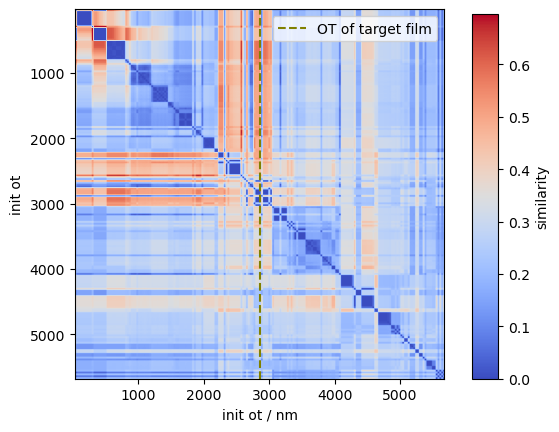

In [49]:
def plot_similarity_matrix(arr, designs):
    fig, ax = plt.subplots(1, 1)
    im = ax.imshow(arr,
                    aspect='equal', 
                    extent=(designs[0].init_ot,
                            designs[-1].init_ot,
                            designs[-1].init_ot,
                            designs[0].init_ot
                    ),
                    cmap='coolwarm'
            )
    ax.set_xlabel('init ot / nm')
    ax.set_ylabel('init ot')

    # show target ot
    wl = 750
    target_ot = designs[0].target_film.get_optical_thickness(wl)
    ax.plot([target_ot, target_ot], ax.get_ylim(), label='OT of target film', c='olive', ls='--')
    ax.legend()

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.82, 0.11, 0.04, 0.76])
    fig.colorbar(im, cax=cbar_ax, label='similarity')
    return fig, ax

fig, ax = plot_similarity_matrix(arr, designs)
fig.savefig("./figs/similarity_matrix.png", dpi=300)